In [2]:
import sys,os,re
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

os.environ['PYTHONPATH']=os.environ.get('SRC')
if not os.environ.get('SRC') in sys.path: 
    sys.path.insert(0,os.environ.get('SRC'))

%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline


import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import seaborn as sns
from scipy import stats
from box import Box
import warnings

from IPython.core.display import display, HTML

warnings.simplefilter('ignore')

D1 = os.environ.get('DAT')+'/shah-2016/'
FIG_DIR = os.environ.get('FIG')

Populating the interactive namespace from numpy and matplotlib


# Hazard identification: Repeat-dose toxicity

We demonstrate the application of genra-py for hazard classification, which is the assignment of a chemical to toxicological category ($\beta$) using two main types of descriptors ($\bf{x}^\alpha$): chemical ($\alpha$=chm) and bioactivity ($\alpha$=bio). Complete details about the source of these data are described in the Methods section of our prior publication [(Shah, Imran, Jie Liu, Richard S. Judson, Russell S. Thomas, and Grace Patlewicz. 2016. “Systematically Evaluating Read-across Prediction and Performance Using a Local Validity Approach Characterized by Chemical Structure and Bioactivity Information.” Regulatory Toxicology and Pharmacology 79: 12–24.)](https://doi.org/10.1016/j.yrtph.2016.05.008).  

    

# Data 

## Supplemental Material

The data files were downloaded from the [supplemental material zip file](https://doi.org/10.1016/j.yrtph.2016.05.008)   (Shah et al 2016) and extracted it in the [data/shah-2016](data/shah-2016) folder. These data files were loaded into pandas dataframes for further analysis. We used a unique chemical identifier (based on the CASRN) for each chemical. 

### Chemical data 
$\bf{x}^{chm}$

Split up data for chemical structure morgan (mrgn), torsion (tptr) and MACCS (mccs) fingperprints in a dictionary. 

In [3]:
CHM1 = pd.read_csv(D1+'S3-chm.tsv',sep='\t')
CHM1_nm = CHM1[['ID','chemical_casrn','chemical_name']].set_index('ID')
X = CHM1 = CHM1.drop(['chemical_casrn','chemical_name'],axis=1).set_index('ID')

CHM11 = Box()
for i in set([i[0] for i in X.columns.str.split('_') ]):
    CHM11[i] = X[X.columns[X.columns.str.match(i)]]
CHM11['all'] = X

Summary

In [4]:
pd.DataFrame([dict(descriptor_type='chm-'+k,
                   n_chemicals=v.shape[0],
                   n_descriptors=v.shape[1]) for k,v in CHM11.items()])

,descriptor_type,n_chemicals,n_descriptors
0,chm-tptr,1792,2048
1,chm-mccs,1792,167
2,chm-mrgn,1792,1024
3,chm-all,1792,3239


### Bioactivity data 
$\bf{x}^{bio}$

Split up the dataframe based on technology platform type

In [5]:
BIO1 = pd.read_excel(D1+'S1-bio.xlsx')
BIO1 = BIO1.drop(['chemical_casrn','chemical_name'],axis=1).set_index('ID')
BIO11 = Box()
for i in ['ACEA', 'APR', 'ATG', 'BSK', 'NVS', 'OT', 'Tox21']:
    BIO11[i] = BIO1[BIO1.columns[BIO1.columns.str.match(i)]]
BIO11['all']=BIO1

In [6]:
pd.DataFrame([dict(descriptor_type='bio-'+k,
                   n_chemicals=v.shape[0],
                   n_descriptors=v.shape[1]) for k,v in BIO11.items()])

,descriptor_type,n_chemicals,n_descriptors
0,bio-ACEA,1792,2
1,bio-APR,1792,60
2,bio-ATG,1792,83
3,bio-BSK,1792,174
4,bio-NVS,1792,420
5,bio-OT,1792,17
6,bio-Tox21,1792,65
7,bio-all,1792,821


A description of the above platforms is available [here](https://www.epa.gov/chemical-research/exploring-toxcast-data-downloadable-data).

### Toxicity data
$\bf{x}^{tox}$

These data were obtained from [ToxRefDB v1](https://cfpub.epa.gov/si/si_public_record_report.cfm?Lab=NCCT&dirEntryId=227139)

In [7]:
TOX1 = pd.read_excel(D1+'S2-tox.xls')
TOX1.set_index('ID',inplace=True)

#set([i[0] for i in BIO1.columns.str.split('_') ])
TOX11 = Box()
for i in set([i[0] for i in TOX1.columns.str.split('_') ]):
    TOX11[i] = TOX1[TOX1.columns[TOX1.columns.str.match(i)]]
    
TOX11['all'] = TOX1

Divide the toxicity data based on repeat-dose guideline animal testing study type:

In [8]:
pd.DataFrame([dict(descriptor_type='tox-'+k,
                   n_chemicals=v.shape[0],
                   n_descriptors=v.shape[1]) for k,v in TOX11.items()])

,descriptor_type,n_chemicals,n_descriptors
0,tox-mgr,607,2
1,tox-dnt,607,57
2,tox-acu,607,18
3,tox-chr,607,83
4,tox-dev,607,95
5,tox-all,607,255


Put all data in one data structure and create a "hybrid" bio+chm descriptor set

In [9]:
DATA = Box(chm=CHM11,bio=BIO11,tox=TOX11)

In [10]:
DATA['bc'] = Box()

for c,b in [(i,j) for i in CHM11.keys() for j in BIO11.keys()]:
    print(b,c)
    DATA['bc']['{}_{}'.format(b,c)] = CHM11[c].merge(BIO11[b],left_index=True,right_index=True)

ACEA tptr
APR tptr
ATG tptr
BSK tptr
NVS tptr
OT tptr
Tox21 tptr
all tptr
ACEA mccs
APR mccs
ATG mccs
BSK mccs
NVS mccs
OT mccs
Tox21 mccs
all mccs
ACEA mrgn
APR mrgn
ATG mrgn
BSK mrgn
NVS mrgn
OT mrgn
Tox21 mrgn
all mrgn
ACEA all
APR all
ATG all
BSK all
NVS all
OT all
Tox21 all
all all


## Chemical structure data

Downloading the structure data is optional: do this only if you want to visualize the nearest neighbours. 

Go to the [US EPA CompTox Dashboard](https://comptox.epa.gov/dashboard/dsstoxdb/batch_search) to download the structures for these chemicals. Open S3-chm.tsv, select the chemical_name column and paste them into the "Enter Identifiers to Search" box. Download the results with dtxsid, name, casrn and smiles (saved below as "genra-2016-smiles-2020-09-15_16_18_44.tsv"). 

In [11]:
SMI=pd.read_csv(D1+'genra-2016-smiles-2020-09-15_16_18_44.tsv',sep='\t')\
        .drop(['INPUT','FOUND_BY'],axis=1)
SMI.columns=SMI.columns.str.lower()
SMI.rename(columns=dict(preferred_name='name',qsar_ready_smiles='smiles'),inplace=True)
SMI.head()

,dtxsid,name,casrn,smiles
0,DTXSID7020005,Acetamide,60-35-5,CC(N)=O
1,DTXSID2020006,Acetaminophen,103-90-2,CC(=O)NC1=CC=C(O)C=C1
2,DTXSID6020014,Dehydroacetic acid,520-45-6,CC(=O)C1C(=O)OC(C)=CC1=O
3,DTXSID0020022,5-(2-Chloro-4-(trifluoromethyl)phenoxy)-2-nitr...,50594-66-6,OC(=O)C1=C(C=CC(OC2=CC=C(C=C2Cl)C(F)(F)F)=C1)[...
4,DTXSID5020027,Acrylamide,79-06-1,NC(=O)C=C


NB - Some chemicals don't have smiles structures

In [12]:
SMI.loc[SMI.smiles=='-'].shape[0]

65

# GenRA Analysis

## Chronic liver toxicity

The chronic liver toxicity data is stored in the TOX1 dataframe (column: chr_liver). We need to create a subset of the data for this analysis.

Get the data through a function -- make life easy

In [13]:

def getData(b,dt='chm',st='all',Data=DATA):
    """
    Return an input and output dataframe for analysis
    
    b = toxicity class
    dt= input data type (chm or bio)
    st= inpute subdata type ()
    """
    
    Y = Data.tox.all[b].dropna()
    Yf= Y.copy()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
    X  = Data[dt][st].loc[Y.index].fillna(0)
    
    return X,Yb
    

There are 433 chemicals with chronic liver toxicity data. 

## Performance for Chronic liver toxicity 

### Using chemical-morgan descriptors for cross-validation testing with k=10

In [14]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer,f1_score,precision_score,recall_score,roc_auc_score
from genra.rax.skl.cls import *

Scorers = dict(f1_score=make_scorer(f1_score),
              precision_score= make_scorer(precision_score),
              recall_score= make_scorer(recall_score),
              roc_auc=make_scorer(roc_auc_score))

GP = GenRAPredClass(n_neighbors=10,metric='jaccard',n_jobs=-1)

X_mrgn,Y_liver = getData('chr_liver',dt='chm',st='all')

P = pd.DataFrame(cross_validate(GP,X_mrgn,Y_liver,cv=10,scoring=Scorers))
R1 = pd.DataFrame(dict(mn=P.mean(),sd=P.std()))
R1

,mn,sd
fit_time,0.060165,0.005948
score_time,0.285316,0.390910
test_f1_score,0.873696,0.023787
test_precision_score,0.800565,0.017066
test_recall_score,0.962353,0.042967
test_roc_auc,0.530621,0.044011


In [28]:
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import cross_validate,StratifiedKFold
from sklearn.metrics import make_scorer,f1_score,precision_score,recall_score,roc_auc_score
from genra.rax.skl.cls import *

cv = StratifiedKFold(5, shuffle=True, random_state=0)

GP = GenRAPredClass(n_neighbors=10,metric='jaccard',n_jobs=-1)

X_mrgn,Y_liver = getData('chr_liver',dt='chm',st='all')

#R = permutation_test_score(GP, X_mrgn, Y_liver, scoring="roc_auc", cv=cv, n_permutations=100,n_jobs=-1)
R = permutation_test_score(GP, X_mrgn, Y_liver, scoring=Scorers, 
                           cv=cv, n_permutations=100,n_jobs=-1)
# The AUC and p-value are:-
auc,p=R[0],R[2]
print(auc,p)

ValueError: For evaluating multiple scores, use sklearn.model_selection.cross_validate instead. {'f1_score': make_scorer(f1_score), 'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score), 'roc_auc': make_scorer(roc_auc_score)} was passed.

(0.6450734234705833, 0.000999000999000999)

## Grid search for best metric and optimal value of k

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    2.0s finished


Best: 0.8834165834165834 {'metric': 'jaccard', 'n_neighbors': 15}


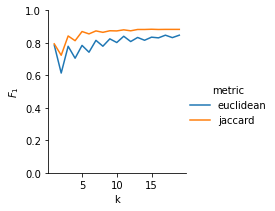

In [14]:
from genra.rax.skl.cls import GenRAPredClass
from sklearn.metrics import make_scorer,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import seaborn as sns

GC1 = GenRAPredClass(algorithm='brute')

params={'n_neighbors': range(1,20),
        'metric':['euclidean','jaccard']
       }


Grid3= GridSearchCV(estimator=GC1,param_grid=params,
                    n_jobs=-1,cv=5,#
                    verbose=1,
                    scoring=make_scorer(f1_score))

Best3=Grid3.fit(X_mrgn,Y_liver)
P = pd.DataFrame(Best3.cv_results_['params'])
P.insert(2,'score_mn',Best3.cv_results_['mean_test_score'])
P.insert(3,'score_std',Best3.cv_results_['std_test_score'])

g=sns.FacetGrid(P,hue='metric')
g.map(pl.plot,'n_neighbors','score_mn')
g.set(ylim=(0,1.0),xlabel='k',ylabel='$F_1$')
g.add_legend()
print("Best:", Best3.best_score_,Best3.best_params_)

## Compare all descriptor types for chronic liver toxicity

In [15]:
from genra.rax.skl.cls import GenRAPredClass
from sklearn.metrics import make_scorer,f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from datetime import datetime

GC = GenRAPredClass(algorithm='brute')
GS = GridSearchCV(estimator=GC,param_grid=params,
                  n_jobs=-1,cv=5,verbose=1,
                  scoring=make_scorer(f1_score))
params={'n_neighbors': range(1,20),
        'metric':['euclidean','jaccard']
       }

t_i = datetime.now()
Res = []
tox_i = 'chr_liver'
for dt_i, st_i in [(i,j) for i in ['chm', 'bio', 'bc'] for j in DATA[i].keys()]:
    X_i,Y_i = getData(tox_i,dt=dt_i,st=st_i,Data=DATA)
    print("\n>{} {} {} chems {} descriptors {}".format(tox_i,dt_i,st_i,X_i.shape[0],X_i.shape[1]))
    try:
        Best_i=GS.fit(X_i,Y_i)
    except:
        print(" Failed ...")
    else:
        P = pd.DataFrame(Best_i.cv_results_['params'])
        P.insert(0,'tox',tox_i)
        P.insert(1,'dt',dt_i)
        P.insert(2,'st',st_i)
        P.insert(3,'score_mn',Best_i.cv_results_['mean_test_score'])
        P.insert(4,'score_std',Best_i.cv_results_['std_test_score'])
        Res.append(P)
t_f = datetime.now()
Perf = pd.concat(Res)


>chr_liver chm tptr chems 433 descriptors 2048
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver chm mrgn chems 433 descriptors 1024
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver chm mccs chems 433 descriptors 167
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver chm all chems 433 descriptors 3239
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



>chr_liver bio ACEA chems 433 descriptors 2
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



>chr_liver bio APR chems 433 descriptors 60
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



>chr_liver bio ATG chems 433 descriptors 83
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



>chr_liver bio BSK chems 433 descriptors 174
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



>chr_liver bio NVS chems 433 descriptors 420
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bio OT chems 433 descriptors 17
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.3s finished



>chr_liver bio Tox21 chems 433 descriptors 65
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



>chr_liver bio all chems 433 descriptors 821
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc ACEA_tptr chems 433 descriptors 2050
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc APR_tptr chems 433 descriptors 2108
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc ATG_tptr chems 433 descriptors 2131
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc BSK_tptr chems 433 descriptors 2222
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc NVS_tptr chems 433 descriptors 2468
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc OT_tptr chems 433 descriptors 2065
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc Tox21_tptr chems 433 descriptors 2113
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.1s finished



>chr_liver bc all_tptr chems 433 descriptors 2869
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc ACEA_mrgn chems 433 descriptors 1026
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.7s finished



>chr_liver bc APR_mrgn chems 433 descriptors 1084
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc ATG_mrgn chems 433 descriptors 1107
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.7s finished



>chr_liver bc BSK_mrgn chems 433 descriptors 1198
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc NVS_mrgn chems 433 descriptors 1444
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc OT_mrgn chems 433 descriptors 1041
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc Tox21_mrgn chems 433 descriptors 1089
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc all_mrgn chems 433 descriptors 1845
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc ACEA_mccs chems 433 descriptors 169
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



>chr_liver bc APR_mccs chems 433 descriptors 227
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



>chr_liver bc ATG_mccs chems 433 descriptors 250
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc BSK_mccs chems 433 descriptors 341
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



>chr_liver bc NVS_mccs chems 433 descriptors 587
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.5s finished



>chr_liver bc OT_mccs chems 433 descriptors 184
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



>chr_liver bc Tox21_mccs chems 433 descriptors 232
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



>chr_liver bc all_mccs chems 433 descriptors 988
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.7s finished



>chr_liver bc ACEA_all chems 433 descriptors 3241
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc APR_all chems 433 descriptors 3299
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc ATG_all chems 433 descriptors 3322
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc BSK_all chems 433 descriptors 3413
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc NVS_all chems 433 descriptors 3659
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc OT_all chems 433 descriptors 3256
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc Tox21_all chems 433 descriptors 3304
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



>chr_liver bc all_all chems 433 descriptors 4060
Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 159 out of 190 | elapsed:    1.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    2.2s finished


In [16]:
t_f-t_i

datetime.timedelta(seconds=46, microseconds=181401)

In [19]:
Perf.head()

,tox,dt,st,score_mn,score_std,metric,n_neighbors
0,chr_liver,chm,mrgn,0.707613,0.113064,euclidean,1
1,chr_liver,chm,mrgn,0.501596,0.127632,euclidean,2
2,chr_liver,chm,mrgn,0.696497,0.143771,euclidean,3
3,chr_liver,chm,mrgn,0.580404,0.167306,euclidean,4
4,chr_liver,chm,mrgn,0.685377,0.193191,euclidean,5


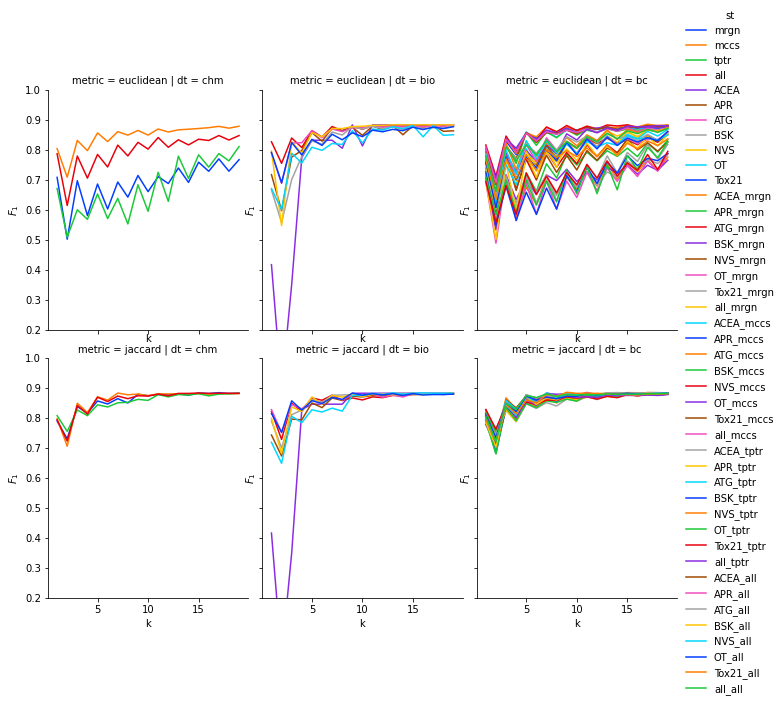

In [20]:
import seaborn as sns

g=sns.FacetGrid(Perf,col='dt',row='metric',hue='st',height=4,aspect=0.8,palette='bright')
g.map(pl.plot,'n_neighbors','score_mn')
g.set(ylim=(0.2,1.0),xlabel='k',ylabel='$F_1$')
g.add_legend()


In [21]:
Perf.sort_values('score_mn',ascending=False).head(10)

,tox,dt,st,score_mn,score_std,metric,n_neighbors
27,chr_liver,bc,Tox21_all,0.885896,0.007871,jaccard,9
29,chr_liver,bc,ACEA_mrgn,0.885441,0.004648,jaccard,11
32,chr_liver,bc,ATG_all,0.884871,0.002118,jaccard,14
35,chr_liver,bc,NVS_mrgn,0.884858,0.002793,jaccard,17
16,chr_liver,bc,ATG_mccs,0.884586,0.004256,euclidean,17
29,chr_liver,bc,APR_all,0.884552,0.005108,jaccard,11
33,chr_liver,bc,ACEA_mrgn,0.884550,0.003042,jaccard,15
36,chr_liver,bc,NVS_mrgn,0.884550,0.003042,jaccard,18
35,chr_liver,chm,mrgn,0.884539,0.005423,jaccard,17
34,chr_liver,bc,ACEA_mrgn,0.884250,0.003094,jaccard,16


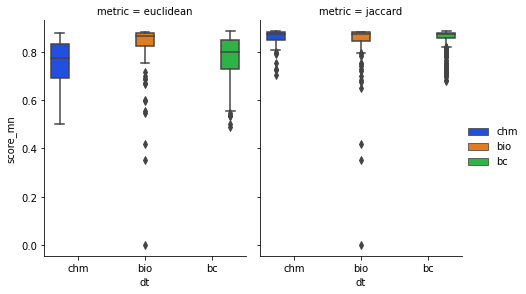

In [22]:
import seaborn as sns

g=sns.catplot(x='dt',y='score_mn',data=Perf,
              kind='box',
              col='metric',hue='dt',height=4,aspect=0.8,palette='bright')
#g.map(pl.plot,'n_neighbors','score_mn')
#g.set(ylim=(0.2,1.0),xlabel='k',ylabel='$F_1$')
g.add_legend()


## All tox 

Evaluate predictive accuracy for all toxcity endpoints with at least 20 chemicals. Investigate F1 scores for the following factors:- 

* k: 1 to 20
* descriptor types: bio, chm, bc
* descriptor subtypes

In [ ]:
from genra.rax.skl.cls import GenRAPredClass
from sklearn.metrics import make_scorer,f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

GC = GenRAPredClass(algorithm='brute')
params={'n_neighbors': range(1,20),
        'metric':['jaccard']
       }
GS = GridSearchCV(estimator=GC,param_grid=params,
                  n_jobs=-1,cv=5,verbose=1,
                  scoring=make_scorer(f1_score))

Res=[]
for tox_i,dt_i, st_i in [(h,i,j) for h in DATA.tox.all.keys() for i in ['chm', 'bio', 'bc'] for j in DATA[i].keys()]:
    X_i,Y_i = getData(tox_i,dt=dt_i,st=st_i,Data=DATA)
    print("\n>{} {} {} chems {} descriptors {}".format(tox_i,dt_i,st_i,X_i.shape[0],X_i.shape[1]))
    if X_i.shape[0]<20: continue
    try:
        Best_i=GS.fit(X_i,Y_i)
    except:
        print(" Failed ...")
    else:
        P = pd.DataFrame(Best_i.cv_results_['params'])
        P.insert(0,'tox',tox_i)
        P.insert(1,'dt',dt_i)
        P.insert(2,'st',st_i)
        P.insert(3,'score_mn',Best_i.cv_results_['mean_test_score'])
        P.insert(4,'score_std',Best_i.cv_results_['std_test_score'])
        P.insert(5,'n_pos',(Y_i==1).sum())
        P.insert(5,'n_neg',(Y_i==0).sum())
        
        Res.append(P)

PERF = pd.concat(Res)

In [ ]:
PERF = pd.concat(Res)
PERF.insert(0,'study',PERF.tox.str.extract('^([^\_]+)_'))
PERF.head(20)

In [ ]:
import seaborn as sns

g=sns.catplot(x='dt',y='score_mn',data=PERF,
              kind='strip',
              col='study',hue='dt',height=4,aspect=0.8,palette='bright')
#g.map(pl.plot,'n_neighbors','score_mn')
#g.set(ylim=(0.2,1.0),xlabel='k',ylabel='$F_1$')
g.add_legend()


In [ ]:
R = []

for tox,Pi in PERF.groupby('tox'):
    R.append(Pi.sort_values('score_mn',ascending=False).iloc[0].to_dict())
    
BEST = pd.DataFrame(R)    

In [ ]:
T1 = BEST.sort_values('score_mn',ascending=False).tox[:20]

import seaborn as sns

g=sns.FacetGrid(PERF[PERF.tox.isin(T1)],
                col='tox',col_wrap=5,hue='dt',
                height=3,aspect=1.0,palette='bright')
g.map(pl.scatter,'n_neighbors','score_mn')
g.set(ylim=(0.2,1.0),xlabel='k',ylabel='$F_1$')
g.add_legend()


In [ ]:
#del(DATA)

In [ ]:
T1 = BEST.sort_values('score_mn',ascending=False).tox[:25]
#T1 = BEST[BEST.tox.str.contains('liver|kidney|brain')].tox.unique()[:10]
import seaborn as sns

g=sns.lmplot(x='n_neighbors',y='score_mn',data=PERF[PERF.tox.isin(T1)],
             col='tox',col_wrap=5,hue='dt',     
             scatter=False,lowess=True,        
             height=2,aspect=1.1,palette='dark')
g.set(ylim=(0.2,1.0),xlabel='k',ylabel='$F_1$')
g.add_legend()


In [ ]:
import seaborn as sns
X = PERF[PERF.tox=='dnt_clinical_chemistry']
g=sns.lmplot(x='n_neighbors',y='score_mn',data=X,
             col='st',col_wrap=5,hue='dt',
             scatter=True,lowess=True,        
             height=2,aspect=1.1,palette='dark')
g.set(ylim=(0.0,1.0),xlabel='k',ylabel='$F_1$')
g.add_legend()


# Figures 

Neighbours and read-across predictions for nitrofen

## Figure 1(a) Visualizing nearest neighbours for nitrofen

In [23]:
CHM_info = CHM1_nm.reset_index().rename(columns=dict(chemical_casrn='casrn')).merge(SMI[['dtxsid','casrn','smiles']],on='casrn')#.set_index('ID')

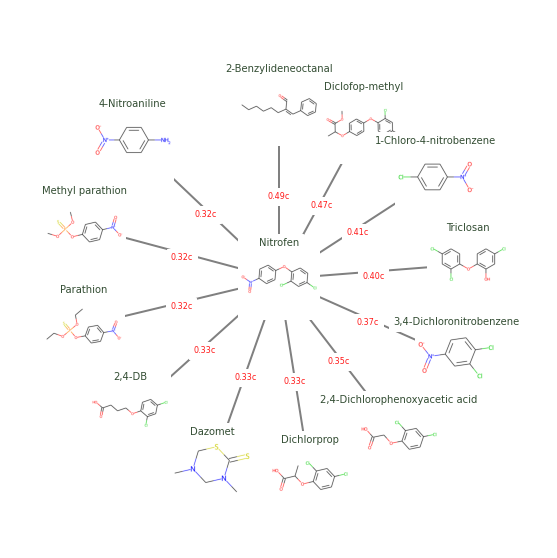

In [24]:
from genra.rax.viz.nn import *

fig = pl.figure(figsize=(10,10))
ax = pl.subplot(1,1,1)
ax.set_axis_off()
ax.set_xlim(-600,600)
ax.set_ylim(-600,600)

target_id = 'C1836755'
GV = GenRAViewNN(rs=1.2,lw=0.2,ax=ax,th_tot=1.9*math.pi,
                 chm_name_font_size=10,
                   chm_sz=(180,180),r_min=200)
GV.loadData(CHM11.mrgn,np.ones(CHM11.mrgn.shape[0]),Info=CHM_info)
GV.draw(target_id,k=12)

<AxesSubplot:>

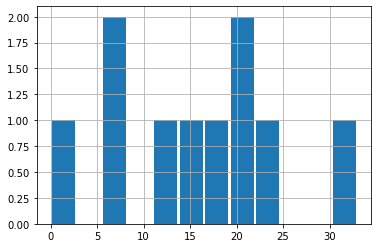

In [25]:
I = TOX1.index.intersection(GV._NNi.ID)
T1 = TOX1.loc[I]#.replace({0:np.nan})
T1[T1>0]=1
N1 = (T1>0).sum().sort_values(ascending=False)
N2 = (T1>0).sum(axis=1).sort_values(ascending=False)

T2 = T1[N1.index[:30]]
T2.T
N2.hist(bins=12,rwidth=0.9)

In [ ]:
N2

## Predict toxicity classifications for target

In [26]:
from genra.rax.skl.cls import GenRAPredClass
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

Scorers = dict(f1_score=make_scorer(f1_score),
              precision_score= make_scorer(precision_score),
              recall_score= make_scorer(recall_score),
              roc_auc=make_scorer(roc_auc_score))



Res = []
dt_i = 'chm'
st_i = 'mrgn'
k = 10
GP = GenRAPredClass(n_neighbors=k,metric='jaccard',n_jobs=-1)
X_t = DATA.chm.mrgn.loc[target_id]
for tox_i in N1.index[:30]:
    X_i,Y_i = getData(tox_i,dt=dt_i,st=st_i,Data=DATA)
    print("\n>{} {} {} chems {} descriptors {}".format(tox_i,dt_i,st_i,X_i.shape[0],X_i.shape[1]))

    P = pd.DataFrame(cross_validate(GP,X_i,Y_i,cv=5,scoring=Scorers))
    GP.fit(X_i,Y_i)    
    Y_t = GP.predict([X_t])
    R = P.mean().to_dict()
    R.update(dict(tox=tox_i,dt=dt_i,st=st_i,pred=Y_t[0]))
    Res.append(R)
    



>chr_body_weight chm mrgn chems 433 descriptors 1024

>chr_hematology chm mrgn chems 433 descriptors 1024

>chr_clinical_chemistry chm mrgn chems 433 descriptors 1024

>chr_liver chm mrgn chems 433 descriptors 1024

>chr_kidney chm mrgn chems 433 descriptors 1024

>dev_body_weight chm mrgn chems 430 descriptors 1024

>dev_reproductive_performance chm mrgn chems 430 descriptors 1024

>dev_bone chm mrgn chems 430 descriptors 1024

>chr_mortality chm mrgn chems 433 descriptors 1024

>dev_clinical_signs chm mrgn chems 430 descriptors 1024

>chr_lung chm mrgn chems 433 descriptors 1024

>dev_food_consumption chm mrgn chems 430 descriptors 1024

>chr_testes chm mrgn chems 433 descriptors 1024

>chr_food_consumption chm mrgn chems 433 descriptors 1024

>chr_clinical_signs chm mrgn chems 433 descriptors 1024

>dev_offspring_survival-early chm mrgn chems 430 descriptors 1024

>chr_spleen chm mrgn chems 433 descriptors 1024

>chr_heart chm mrgn chems 433 descriptors 1024

>dev_maternal_wastage 

In [27]:
Perf = pd.DataFrame(Res).sort_values('test_f1_score',ascending=False)
I = [1,2,5,8,9,10,11,12,13,14]
Perf.iloc[I]

,fit_time,score_time,test_f1_score,test_precision_score,test_recall_score,test_roc_auc,tox,dt,st,pred
0,0.021341,0.174786,0.951572,0.907618,1.000000,0.500000,chr_body_weight,chm,mrgn,1
3,0.019897,0.165846,0.874117,0.799315,0.964919,0.525734,chr_liver,chm,mrgn,1
11,0.021950,0.147397,0.767957,0.699490,0.852671,0.474335,dev_food_consumption,chm,mrgn,1
7,0.020113,0.164542,0.635754,0.624363,0.657306,0.556431,dev_bone,chm,mrgn,1
24,0.009128,0.050872,0.601128,0.551111,0.677778,0.481746,dnt_clinical_signs,chm,mrgn,1
14,0.020793,0.161538,0.568509,0.596401,0.548227,0.544559,chr_clinical_signs,chm,mrgn,0
6,0.021226,0.170949,0.464108,0.523033,0.422222,0.506233,dev_reproductive_performance,chm,mrgn,1
8,0.023873,0.141430,0.294420,0.390052,0.237692,0.459272,chr_mortality,chm,mrgn,0
13,0.023549,0.143552,0.270158,0.508046,0.194286,0.517392,chr_food_consumption,chm,mrgn,0
18,0.021301,0.169968,0.265988,0.486464,0.192540,0.536001,dev_maternal_wastage,chm,mrgn,0


In [28]:

P_target=Perf[['tox','pred','test_f1_score']].set_index('tox')
T2.loc[target_id] = P_target.loc[T2.columns].pred
T2 = pd.concat((T2.iloc[[-1],:],T2.iloc[:-1,:]))


## Figure 1(b): Visualizing hazard classes & predictions for nitrofen 

[Text(0.5, 15.0, '')]

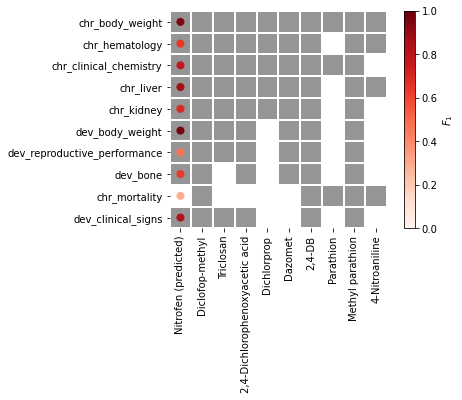

In [29]:
T3 = T2[N1.index[:10]].loc[[i for i in GV._NNi.ID if i in T2.index]].reset_index()\
                .merge(CHM_info[['ID','chemical_name']],on='ID').drop('ID',axis=1)\
                .set_index('chemical_name')
T3 = T3.drop('1-Chloro-4-nitrobenzene',axis=0).T
T3.rename(columns=dict(Nitrofen='Nitrofen (predicted)'),inplace=True)
#A3 = pd.DataFrame(np.zeros(T3.shape),index=T3.index,columns=T3.columns)
#A3['Nitrofen'] = 
g = sns.heatmap(T3,lw=1,cmap=cm.Greys,vmax=2,cbar=False,square=True)
n = T3.shape[0]
sc=g.axes.scatter(0.5*np.ones(n),np.arange(n)+0.5,s=50,
               c=P_target.loc[T3.index].test_f1_score,
               cmap=cm.Reds,vmin=0,vmax=1
              )
pl.colorbar(sc,label='$F_1$')
g.set(xlabel='')
